In [1]:
%reload_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
from markovsbi.bm.plot_utils import plot_metric_by_eval_steps, multi_plot, use_style
from markovsbi.bm.data_utils import query, load_model
from markovsbi.tasks import get_task
from functools import partial

import jax 
import jax.numpy as jnp
import numpy as np
import torch

import matplotlib.pyplot as plt

In [3]:
df = query("results/bm_lv100k", method="diffusion", num_simulations=100000, seed=0)

(method=='diffusion') & (num_simulations==100000) & (seed==0)


In [118]:
task = get_task("lotka_volterra")
prior = task.get_prior()
simulator = task.get_simulator()

In [119]:
model = load_model("results/bm_lv100k", 16)

In [120]:
key = jax.random.PRNGKey(0)
key, key1, key2 = jax.random.split(key,3)

thetas = prior.sample(key1, (1000,))
xs = jax.vmap(lambda k, t : simulator(k,t, 21))(jax.random.split(key2, 1000), thetas)

In [121]:
@jax.jit
@jax.vmap
def sample(key, x):
    return model.sample((500,), x_o=x,rng=key)


calibration_metrics = []
for T in [2, 6, 11, 21,51,101]:
    thetas = prior.sample(key1, (1000,))
    xs = jax.vmap(lambda k, t : simulator(k,t, T))(jax.random.split(key2, 1000), thetas)
    samples = jnp.concatenate([sample(jax.random.split(key+1, 20), xs[i*20:(i+1)*20]) for i in range(50)],axis=0)
    calibration = jnp.sum((samples < thetas[:, None,...]), axis=1)
    calibration_metrics.append(calibration)


jnp.save("calibration_fnse", calibration_metrics)

In [97]:
samples.shape

(1000, 500, 4)

In [98]:
calibration = jnp.sum((samples < thetas[:, None,...]), axis=1)

In [99]:
def compute_empirical_cdf(samples, num_bins=50):
    # Define bins
    hist, bin_edges = np.histogram(samples, bins=num_bins, density=False)
    
    # Calculate CDF values based on bin counts
    cdf_values = np.cumsum(hist) / np.sum(hist)  # Cumulative sum normalized
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
    
    return bin_centers, cdf_values

bins, cdfs = compute_empirical_cdf(calibration[:,1])

In [100]:
cdfs.shape

(50,)

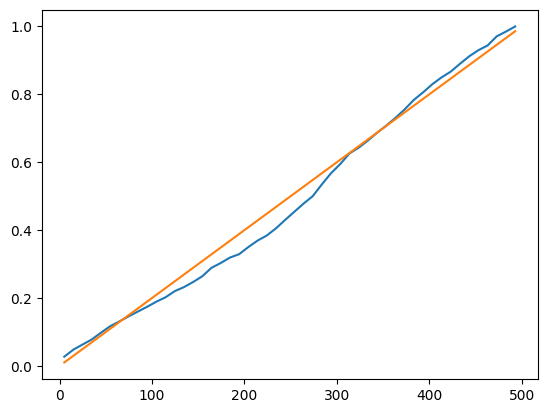

In [101]:
plt.plot(bins,cdfs)
plt.plot(bins, bins/500)


In [8]:
df = query("results/bm_lv100k", method="npe", num_simulations=10000, seed=0)
df

(method=='npe') & (num_simulations==10000) & (seed==0)


,method,sampler,task,num_simulations,num_steps,seed,model_id,metric,value,eval_num_steps,time_train,time_eval,cfg
6,npe,direct,lotka_volterra,10000,10,0,1,swd,0.590631,2,286.637111,0.067712,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."
7,npe,direct,lotka_volterra,10000,10,0,1,swd,0.404198,11,286.637111,0.067712,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."
8,npe,direct,lotka_volterra,10000,10,0,1,swd,1.076966,101,286.637111,0.067712,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."
9,npe,direct,lotka_volterra,10000,10,0,1,c2st,0.869650,2,286.637111,0.026836,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."
10,npe,direct,lotka_volterra,10000,10,0,1,c2st,0.909100,11,286.637111,0.026836,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."
11,npe,direct,lotka_volterra,10000,10,0,1,c2st,0.991000,101,286.637111,0.026836,"{'name': 'bm_lv100k', 'seed': 0, 'model_id': N..."


In [113]:
model_npe = load_model("results/bm_lv100k", 1)

/mnt/qb/work/macke/mgloeckler90/miniconda3/envs/markovsbi/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

In [114]:
key = jax.random.PRNGKey(0)
key, key1, key2 = jax.random.split(key,3)

thetas = prior.sample(key1, (1000,))
xs = jax.vmap(lambda k, t : simulator(k,t, 21))(jax.random.split(key2, 1000), thetas)

In [115]:
thetas = prior.sample(key1, (1000,))
xs = jax.vmap(lambda k, t : simulator(k,t, 21))(jax.random.split(key2, 1000), thetas)
xs_torch = torch.tensor(np.array(xs))
thetas_torch = torch.tensor(np.array(thetas))

In [116]:
xs_torch.shape

torch.Size([1000, 21, 2])

In [148]:
calibration_metrics_npe = []
for T in [2,6,11,21,51,101]:
    thetas = prior.sample(key1, (1000,))
    xs = jax.vmap(lambda k, t : simulator(k,t, T))(jax.random.split(key2, 1000), thetas)
    xs_torch = torch.tensor(np.array(xs))
    thetas_torch = torch.tensor(np.array(thetas))
    samples = []
    for i in range(xs_torch.shape[0]):
        samples_i = model_npe.sample(500, x_o=xs_torch[i])
        samples.append(samples_i[None,...])
    samples = torch.concatenate(samples,axis=0)    
    calibration = torch.sum((samples < thetas_torch[:, None,...]), axis=1)
    calibration_metrics_npe.append(calibration)

torch.save(calibration_metrics_npe,"calibration_npe")

/mnt/qb/work/macke/mgloeckler90/miniconda3/envs/markovsbi/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 2 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])
/mnt/qb/work/macke/mgloeckler90/miniconda3/envs/markovsbi/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 6 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect 

In [85]:
calibration = torch.sum((samples < thetas_torch[:, None,...]), axis=1)

In [94]:
bins, cdfs = compute_empirical_cdf(calibration[:,1])

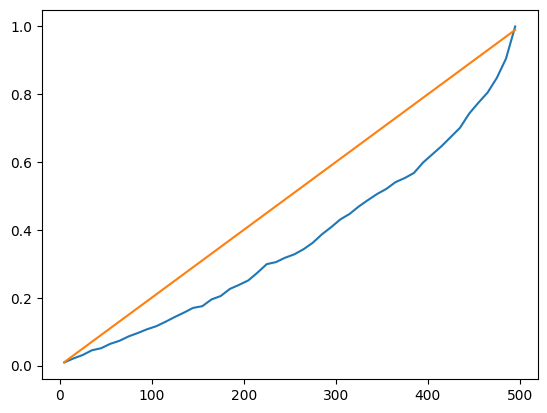

In [95]:
plt.plot(bins,cdfs)
plt.plot(bins,bins/500)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


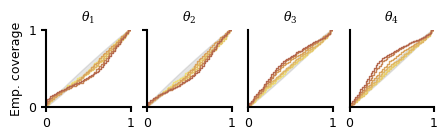

In [168]:
from markovsbi.bm.plot_utils import use_style
from scipy.stats import binom
import numpy as np
# Construct uniform histogram.
num_sbc_runs = 1000
num_bins=50
num_samples=500
color="grey"
alpha = 0.2
uni_bins = binom(num_sbc_runs, p=1 / num_bins).ppf(0.5) * np.ones(num_bins)
uni_bins_cdf = uni_bins.cumsum() / uni_bins.sum()
# Decrease value one in last entry by epsilon to find valid
# confidence intervals.
uni_bins_cdf[-1] -= 1e-9


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
color1 = "#EEDF7A"
color2 = "#D8A25E"
color3 = "#A04747"


colors = [color1, color2, color3]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)


lower = [binom(num_sbc_runs, p=p).ppf(0.005) for p in uni_bins_cdf]
upper = [binom(num_sbc_runs, p=p).ppf(0.995) for p in uni_bins_cdf]

lower = np.array(lower)
upper = np.array(upper)



with use_style("pyloric"):
    fig,axes = plt.subplots(1,4, figsize=(5,1))
      # Plot grey area with expected ECDF.
    axes[0].fill_between(
        x=np.arange(0, num_samples,num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )

    axes[1].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )

    axes[2].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )
    axes[3].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )

    axes[1].set_yticks([0,1])
    axes[1].set_yticklabels([])
    axes[2].set_yticks([0,1])
    axes[2].set_yticks([])
    axes[3].set_yticks([0,1])
    axes[3].set_yticks([])
    axes[0].set_yticks([0,1])

    axes[0].set_title(r"$\theta_1$")
    axes[1].set_title(r"$\theta_2$")
    axes[2].set_title(r"$\theta_3$")
    axes[3].set_title(r"$\theta_4$")

    axes[0].set_ylabel(r"")
    Ts = [2, 6, 11, 21,51,101]
    for t in range(6):
        for i in range(4):
            sorted_samples, cdf_values = compute_empirical_cdf(calibration_metrics[t][:,i])
            l1, = axes[i].step(sorted_samples,cdf_values, color=cmap((t*16.6-1)/100), label=f"T={Ts[t]-1}", lw=1)
            axes[i].set_xticks([0,500])
            axes[i].set_xticklabels([0,1])
            axes[i].set_ylim(0,1)
            axes[i].set_xlim(0,500)

    axes[0].set_ylabel("Emp. coverage")
    fig.savefig("coverage_lv.svg")


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

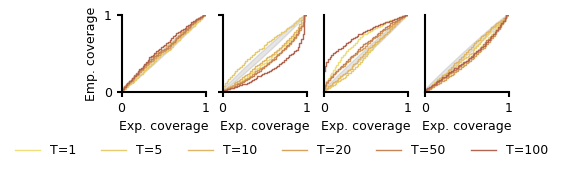

In [167]:
from markovsbi.bm.plot_utils import use_style
from scipy.stats import binom
import numpy as np
# Construct uniform histogram.
num_sbc_runs = 1000
num_bins=50
num_samples=500
color="grey"
alpha = 0.2
uni_bins = binom(num_sbc_runs, p=1 / num_bins).ppf(0.5) * np.ones(num_bins)
uni_bins_cdf = uni_bins.cumsum() / uni_bins.sum()
# Decrease value one in last entry by epsilon to find valid
# confidence intervals.
uni_bins_cdf[-1] -= 1e-9


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
color1 = "#EEDF7A"
color2 = "#D8A25E"
color3 = "#A04747"


colors = [color1, color2, color3]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)


lower = [binom(num_sbc_runs, p=p).ppf(0.005) for p in uni_bins_cdf]
upper = [binom(num_sbc_runs, p=p).ppf(0.995) for p in uni_bins_cdf]

lower = np.array(lower)
upper = np.array(upper)



with use_style("pyloric"):
    fig,axes = plt.subplots(1,4, figsize=(5,1.0))
      # Plot grey area with expected ECDF.
 
    axes[1].set_yticks([0,1])
    axes[1].set_yticklabels([])
    axes[2].set_yticks([0,1])
    axes[2].set_yticks([])
    axes[3].set_yticks([0,1])
    axes[3].set_yticks([])
    axes[0].set_yticks([0,1])



    axes[0].set_ylabel(r"")
    Ts = [2, 6, 11, 21,51,101]
    for t in range(6):
        for i in range(4):
            sorted_samples, cdf_values = compute_empirical_cdf(calibration_metrics_npe[t][:,i])
            l1, = axes[i].step(sorted_samples,cdf_values, color=cmap(t*16.6/100), label=f"T={Ts[t]-1}", lw=1)
            axes[i].set_xticks([0,500])
            axes[i].set_xticklabels([0,1])
            axes[i].set_ylim(0,1)
            axes[i].set_xlim(0,500)

    axes[0].fill_between(
        x=np.arange(0, num_samples,num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )

    axes[1].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )

    axes[2].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )
    axes[3].fill_between(
        x=np.arange(0, num_samples, num_samples//num_bins),
        y1=lower / lower.max(),
        y2=upper / upper.max(),  # pyright: ignore[reportArgumentType]
        color=color,
        alpha=alpha,
        label="expected under uniformity",
    )


    axes[0].set_ylabel("Emp. coverage")
    axes[0].set_xlabel("Exp. coverage")
    axes[1].set_xlabel("Exp. coverage")
    axes[2].set_xlabel("Exp. coverage")
    axes[3].set_xlabel("Exp. coverage")

    fig.legend([f"T={Ts[t]-1}" for t in range(6)], ncol=6, bbox_to_anchor=(1.,-0.3))
    fig.savefig("coverage_lv_npe.svg")


In [3]:
DEFAULT_COLORS = {"nle": "#1e81b0", "nre": "#9bf2fa", "diffusion": "#f2a900", "npe": "#060169", "npe_summary": "#05a599",  "npe_sliced_summary": "#a1a5a9", "nse":"#f2d900" }

col_size = 1.5
row_size = 1.3

In [43]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
    fig.savefig("figures/fig_rebutal/bm_10k_original.svg")

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='double_well') & (num_steps==2|num_steps==11) & (metric=='c2st')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [44]:
from io import StringIO
df = query("results/bm_synthetic_10k", task="general_sde", method="nre", eval_num_steps=101)


# Write DataFrame to the buffer
df.to_csv("test.csv", index=False)

df


(method=='nre') & (task=='general_sde') & (eval_num_steps==101)


,method,sampler,task,num_simulations,num_steps,seed,model_id,metric,value,eval_num_steps,time_train,time_eval,cfg
182,nre,mcmc,general_sde,10000,2,1,30,swd,1.200036,101,39.479699,29.681456,"{'name': 'bm_synthetic_10k', 'seed': 1, 'model..."
185,nre,mcmc,general_sde,10000,2,1,30,c2st,0.992400,101,39.479699,43.317691,"{'name': 'bm_synthetic_10k', 'seed': 1, 'model..."
188,nre,mcmc,general_sde,10000,2,2,31,swd,1.028935,101,15.080262,30.005682,"{'name': 'bm_synthetic_10k', 'seed': 2, 'model..."
191,nre,mcmc,general_sde,10000,2,2,31,c2st,0.988350,101,15.080262,44.465786,"{'name': 'bm_synthetic_10k', 'seed': 2, 'model..."
194,nre,mcmc,general_sde,10000,2,0,32,swd,1.401672,101,52.808839,30.212687,"{'name': 'bm_synthetic_10k', 'seed': 0, 'model..."
197,nre,mcmc,general_sde,10000,2,0,32,c2st,0.995850,101,52.808839,44.118068,"{'name': 'bm_synthetic_10k', 'seed': 0, 'model..."
224,nre,mcmc,general_sde,10000,2,4,37,swd,1.314315,101,7.351480,32.106958,"{'name': 'bm_synthetic_10k', 'seed': 4, 'model..."
227,nre,mcmc,general_sde,10000,2,4,37,c2st,0.997550,101,7.351480,45.381158,"{'name': 'bm_synthetic_10k', 'seed': 4, 'model..."
380,nre,mcmc,general_sde,10000,2,0,63,swd,1.401672,101,20.785873,30.900950,"{'name': 'bm_synthetic_10k', 'seed': 0, 'model..."
383,nre,mcmc,general_sde,10000,2,0,63,c2st,0.995850,101,20.785873,41.918801,"{'name': 'bm_synthetic_10k', 'seed': 0, 'model..."


In [44]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k_more_eval",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        # ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
    fig.savefig("figures/fig_rebutal/bm_10k_more_eval.svg")

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion') & (task=='double_well') & (num_steps==2|num_steps==11) & (metric=='c2st')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary'|method=='nse') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary'|method=='nse') & (task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary'|method=='nse') & (task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary'|method=='nse') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_s

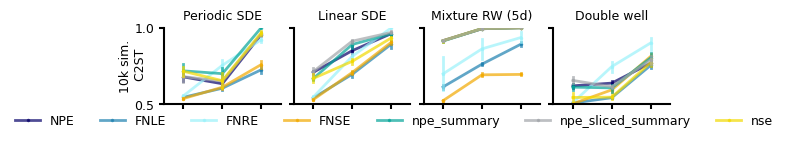

In [80]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_100k_appendix",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary", "nse"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

In [144]:
df = query("results/bm_synthetic_10k_appendix",task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nle_summary", "nle_sliced_summary", "nre", "npe", "npe_summary", "diffusion", "nse", "npe_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='nle'|method=='nle_summary'|method=='nle_sliced_summary'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='nse'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')


In [146]:
grouped_metrics[:,"nse"]

task           eval_num_steps
double_well    2                 0.59707
               11                0.58618
               101               0.79201
general_sde    2                 0.68582
               11                0.92576
               101               0.96957
mixture_rw_5d  2                 0.91064
               11                0.99202
               101               0.99853
periodic_sde   2                 0.77696
               11                0.92584
               101               0.97818
Name: value, dtype: float64

In [5]:
df = query("results/bm_synthetic_100k_appendix",task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nle_summary", "nle_sliced_summary", "nre", "npe", "npe_summary", "diffusion", "nse", "npe_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='nle'|method=='nle_summary'|method=='nle_sliced_summary'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='nse'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')


In [7]:
grouped_metrics[:,"nse"]

task           eval_num_steps
double_well    2                 0.54215
               11                0.54411
               101               0.77040
general_sde    2                 0.66665
               11                0.77866
               101               0.93092
mixture_rw_5d  2                 0.91427
               11                0.99315
               101               0.99847
periodic_sde   2                 0.71344
               11                0.65195
               101               0.96629
Name: value, dtype: float64

In [128]:
df = query("results/bm_synthetic_10k_alt_embedding",task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "nse", "npe_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='nse'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')


In [81]:
grouped_metrics

task          method     eval_num_steps
double_well   diffusion  2                 0.501305
                         11                0.591850
                         101               0.810975
              nle        2                 0.505720
                         11                0.540550
                                             ...   
periodic_sde  nre        11                0.752570
                         101               0.920090
              nse        2                 0.713440
                         11                0.651950
                         101               0.966290
Name: value, Length: 84, dtype: float64

In [188]:
df = query("results/bm_synthetic_1000k",task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "nse", "npe_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='nse'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')


In [189]:
grouped_metrics

task           method     eval_num_steps
double_well    diffusion  2                 0.500783
                          11                0.543950
                          101               0.724117
               npe        2                 0.566233
                          11                0.547933
                          101               0.844267
general_sde    diffusion  2                 0.527567
                          11                0.678150
                          101               0.842683
               npe        2                 0.570612
                          11                0.647687
                          101               0.923925
mixture_rw_5d  diffusion  2                 0.513133
                          11                0.673933
                          101               0.615417
               npe        2                 0.858800
                          11                0.968662
                          101               0.999387
perio

In [19]:
df = query("results/bm_lv100k", num_steps=[2,11,10], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "nse", "npe_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='nse'|method=='npe_sliced_summary') & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')


In [20]:
df.method.unique()

array(['npe', 'nle', 'nre', 'diffusion', 'nse'], dtype=object)

In [22]:
grouped_metrics[:,"nse" ]

task            eval_num_steps
lotka_volterra  2                 0.841065
                11                0.937920
                101               0.992275
Name: value, dtype: float64

In [180]:
df = query("results/bm_sir100k_extended", num_simulations=1000, num_steps=[2,11,10], metric="c2st", method=["npe", "npe_summary", "npe_sliced_summary", "nse", "nle_summary", "nle_sliced_summary"])

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(method=='npe'|method=='npe_summary'|method=='npe_sliced_summary'|method=='nse'|method=='nle_summary'|method=='nle_sliced_summary') & (num_simulations==1000) & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')


In [178]:
df = query("results/bm_sir10k", num_simulations=1000, num_steps=[2,11,10], metric="c2st")

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(num_simulations==1000) & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')


In [181]:
df.method.unique()

array(['npe_summary', 'npe_sliced_summary', 'nle_summary',
       'nle_sliced_summary'], dtype=object)

In [182]:
grouped_metrics

task  method              eval_num_steps
sir   nle_sliced_summary  2                 0.97400
                          11                0.99632
                          101               0.99737
      nle_summary         2                 0.97942
                          11                0.99374
                          101               0.99858
      npe_sliced_summary  2                 0.98553
                          11                0.99642
                          101               0.99724
      npe_summary         2                 0.98614
                          11                0.99023
                          101               0.99623
Name: value, dtype: float64

In [78]:
df = query("results/bm_synthetic_100k_long_sims", metric="c2st")

grouped_metrics = df.groupby(["task","method", "eval_num_steps"]).mean(True)["value"]

(metric=='c2st')


In [28]:
grouped_metrics

task           method  eval_num_steps
double_well    npe     2                 0.63938
                       11                0.68963
                       101               0.76220
general_sde    npe     2                 0.71425
                       11                0.92513
                       101               0.96860
mixture_rw_5d  npe     2                 0.91405
                       11                0.99229
                       101               0.99869
periodic_sde   npe     2                 0.81854
                       11                0.83874
                       101               0.87561
Name: value, dtype: float64

(method=='diffusion') & (num_simulations==100000)
1.4
(1.4, 2.22)
(method=='diffusion') & (task=='sir') & (num_simulations==100000) & (metric=='c2st')
(method=='diffusion') & (task=='sir') & (num_simulations==100000) & (metric=='swd')


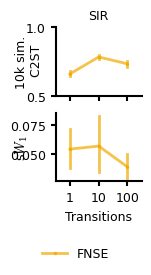

In [141]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_sir100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, num_simulations=100_000, method="diffusion", figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS,fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

1.4
(5.6, 2.22)
(task=='periodic_sde') & (metric=='c2st')
(task=='general_sde') & (metric=='c2st')
(task=='mixture_rw_5d') & (metric=='c2st')
(task=='double_well') & (metric=='c2st')
(task=='periodic_sde') & (metric=='swd')
(task=='general_sde') & (metric=='swd')
(task=='mixture_rw_5d') & (metric=='swd')
(task=='double_well') & (metric=='swd')


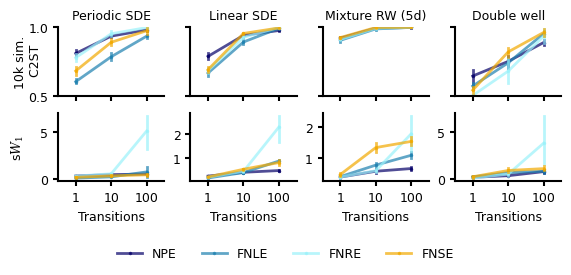

In [154]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_1k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS,fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

1.4
(1.4, 2.22)
(task=='lotka_volterra') & (metric=='c2st')
(task=='lotka_volterra') & (metric=='swd')


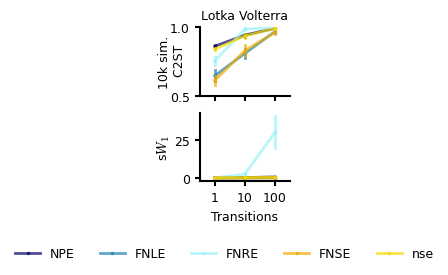

In [191]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_lv100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS,fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

1.4
(1.4, 2.22)
(task=='lotka_volterra') & (metric=='c2st')
(task=='lotka_volterra') & (metric=='swd')


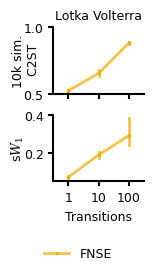

In [190]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_lv100k_good_proposal",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS,fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well') & (num_steps==2|num_ste

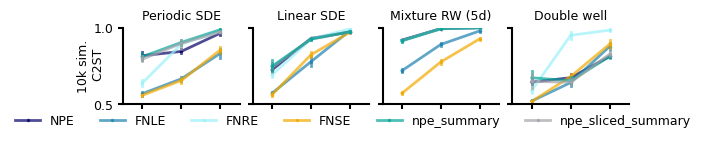

In [19]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k_appendix",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well') & (num_steps==2|num_ste

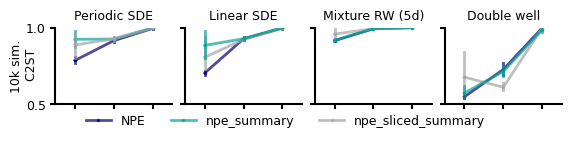

In [17]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k_alt_embedding",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(metric=='c2st')
1.4
(5.6, 1.11)
(task=='periodic_sde') & (metric=='c2st')
(task=='general_sde') & (metric=='c2st')
(task=='mixture_rw_5d') & (metric=='c2st')
(task=='double_well') & (metric=='c2st')


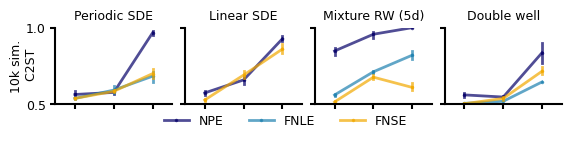

In [198]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_1000k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, metric="c2st", fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='periodic_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='general_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well') & (num_steps==2|num_ste

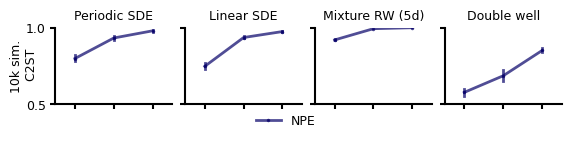

In [18]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k_long_sims",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,51], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
1.4
(5.6, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='periodic_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='general_sde') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='mixture_rw_5d') & (num_steps==2|num_steps==51) & (metric=='c2st')
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='double_well') & (num_steps==2|num_ste

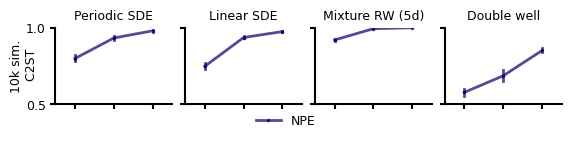

In [15]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_synthetic_10k_long_sims",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,51], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')
1.4
(1.4, 1.11)


/mnt/qb/work/macke/mgloeckler90/marcov_sbi/markovsbi/bm/plot_utils.py:317: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)


(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='lotka_volterra') & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')


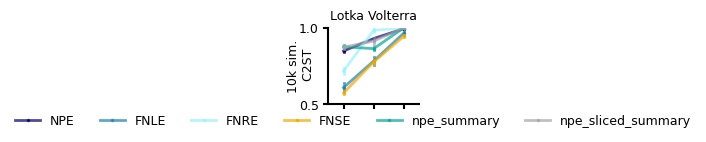

In [33]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_lv100k_extended",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, num_steps=[2,11,10], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')
1.4
(1.4, 1.11)
(method=='nle'|method=='nre'|method=='npe'|method=='npe_summary'|method=='diffusion'|method=='npe_sliced_summary') & (task=='sir') & (num_steps==2|num_steps==11|num_steps==10) & (metric=='c2st')


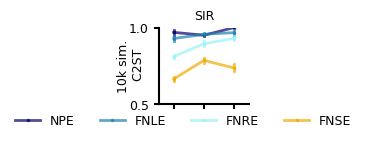

In [34]:
with use_style("pyloric"):
    fig, axes = multi_plot("results/bm_sir100k_extended",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.19,color_map=DEFAULT_COLORS, num_steps=[2,11,10], metric="c2st", method=["nle", "nre", "npe", "npe_summary", "diffusion", "npe_sliced_summary"], fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("10k sim.\n\u00A0C2ST", x=-0.15)
    #fig.savefig("bm_10k_c2st.svg")
fig

In [18]:
with use_style("pyloric"):
    fig, axes = multi_plot("../../results/bm_synthetic_10k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size - 0.1, figsize_per_row=row_size-0.09,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="swd", fig_legend=False)

    for i,ax in enumerate(axes[0]):
        ax.set_yscale("log", base=2)
        # ax.set_ylim(0., 16.)
        # ax.set_yticks([2**-4, 2**0,2**4])
        # ax.set_yticklabels([r"$2^{\text{-}4}$", "$2^0$", "$2^4$"])
        ax.set_xlabel("")
        ax.set_xticklabels([])
        
    axes[0,0].set_yticks([2**-3, 2**-1])
    axes[0,0].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{\text{-}1}$"])
    axes[0,1].set_yticks([2**-3, 2**0])
    axes[0,1].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{0}$"])
    axes[0,2].set_yticks([2**-3, 2**-1])
    axes[0,2].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{\text{-}1}$"])
    axes[0,3].set_yticks([2**-2, 2**2])
    axes[0,3].set_yticklabels([r"$2^{\text{-}2}$", r"$2^{2}$"])
            
    axes[0,0].set_ylabel(r"""s$W_1$ (10k sim.)""")
    fig.savefig("bm_10k.svg")
fig


KeyboardInterrupt



(task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
1.4
(5.6, 1.3)
(task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='c2st')
(task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='c2st')
(task=='double_well') & (num_steps==2|num_steps==11) & (metric=='c2st')


/tmp/ipykernel_498800/887439202.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/887439202.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/887439202.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/887439202.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic f

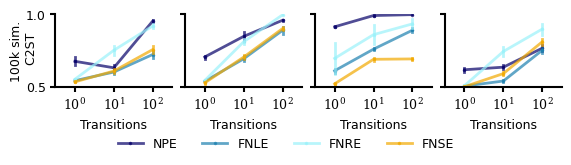

In [176]:
with use_style("pyloric"):
    fig, axes = multi_plot("../../results/bm_synthetic_100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.5, -0.2),  figsize_per_col=col_size-0.1, figsize_per_row=row_size,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="c2st", fig_legend=True)

    for i,ax in enumerate(axes[0]):
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_title(None)
        # ax.set_xlabel("")
        ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
        
        
        if i > 0:
            ax.set_yticklabels([])
            
    axes[0,0].set_ylabel("100k sim.\n\u00A0C2ST", x=-0.15)
    fig.savefig("bm_100k_c2st.svg")
fig

(task=='double_well'|task=='mixture_rw_5d'|task=='periodic_sde'|task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='swd')
1.4
(5.6, 1.4000000000000001)
(task=='periodic_sde') & (num_steps==2|num_steps==11) & (metric=='swd')
(task=='general_sde') & (num_steps==2|num_steps==11) & (metric=='swd')
(task=='mixture_rw_5d') & (num_steps==2|num_steps==11) & (metric=='swd')
(task=='double_well') & (num_steps==2|num_steps==11) & (metric=='swd')


/tmp/ipykernel_498800/1905371923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/1905371923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/1905371923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
/tmp/ipykernel_498800/1905371923.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: G

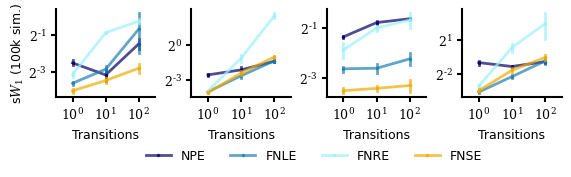

In [177]:
from matplotlib.ticker import MaxNLocator
with use_style("pyloric"):
    fig, axes = multi_plot("../../results/bm_synthetic_100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="method"), legend_bbox_to_anchor=(0.55, -0.2),  figsize_per_col=col_size-0.1, figsize_per_row=row_size +0.1 ,color_map=DEFAULT_COLORS, task=["double_well", "mixture_rw_5d", "periodic_sde", "general_sde"], num_steps=[2,11], metric="swd")
    #plt.subplots_adjust(wspace=-0.5)
    for i,ax in enumerate(axes[0]):
        ax.set_yscale("log", base=2)
        # ax.set_ylim(0., 16.)
        # ax.set_yticks([2**-4, 2**0,2**4])
        # ax.set_yticklabels([r"$2^{\text{-}4}$", "$2^0$", "$2^4$"])
        #ax.set_xlabel("")
        ax.set_title(None)
        ax.set_xticklabels([])
        ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$"])
    
    axes[0,0].set_yticks([2**-3, 2**-1])
    axes[0,0].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{\text{-}1}$"])
    axes[0,1].set_yticks([2**-3, 2**0])
    axes[0,1].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{0}$"])
    axes[0,2].set_yticks([2**-3, 2**-1])
    axes[0,2].set_yticklabels([r"$2^{\text{-}3}$", r"$2^{\text{-}1}$"])
    axes[0,3].set_yticks([2**-2, 2**1])
    axes[0,3].set_yticklabels([r"$2^{\text{-}2}$", r"$2^{1}$"])
            
    axes[0,0].set_ylabel(r"""s$W_1$ (100k sim.)""")
        
    fig.savefig("bm_100k.svg")
fig

In [178]:
df = query("../../results_old/bm_sampler100k",sampler=["em_fnpe", "em_gaus", "em_jac"], metric="c2st", eval_num_steps=501)
stat = df[["sampler","time_eval"]]

stat["time_eval"] = stat["time_eval"].astype(float)

stat = stat.groupby("sampler").mean()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (metric=='c2st') & (eval_num_steps==501)


/tmp/ipykernel_498800/689184626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat["time_eval"] = stat["time_eval"].astype(float)


In [179]:
df = query("../../results/bm_sampler100k",sampler=["pc_fnpe", "pc_gaus", "pc_jac"], metric="c2st")

(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (metric=='c2st')


(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary'|task=='mixture_rw_5d') & (seed==0|seed==1|seed==2) & (metric=='c2st')
2.2
(2.2, 1.7333333333333334)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (seed==0|seed==1|seed==2) & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (seed==0|seed==1|seed==2) & (metric=='c2st')


/tmp/ipykernel_498800/2644429897.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0.5,1.])
/tmp/ipykernel_498800/2644429897.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0.5,1.])
/tmp/ipykernel_498800/2644429897.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following 

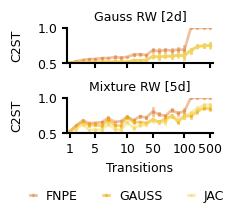

In [237]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "metric", "task", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.5), legend_bbox_to_anchor=(0.55, -0.2),color_map=colors, figsize_per_col=col_size+0.7, figsize_per_row=row_size/1.5, metric=["c2st"], fig_legend=True, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, task=["simple2dstationary", "mixture_rw_5d"], legend_kwargs={"handlelength":0.5}, seed=[0,1,2])
    for i,ax in enumerate(axes[:,0]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        ax.set_ylim(0.5,1.)
        ax.set_yticklabels([0.5,1.])
        ax.set_yticks([0.5,1.])
        ax.set_ylabel("C2ST")
 
        if i < len(axes[:,0])-1:
            ax.set_xticklabels([])
            ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        else:
            ax.set_xticklabels([1,5,10, 50,100,500])
            ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            
    axes[0,0].set_title("Gauss RW [2d]")
    axes[1,0].set_title("Mixture RW [5d]")
    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers.svg", transparent=True)

    plt.show()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary'|task=='mixture_rw_5d') & (metric=='swd')
2.2
(2.2, 1.7333333333333334)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (metric=='swd')


/tmp/ipykernel_498800/3536865394.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found becaus

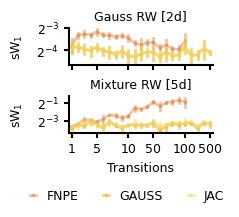

In [238]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "metric", "task", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.5), legend_bbox_to_anchor=(0.55, -0.2),color_map=colors, figsize_per_col=col_size+0.7, figsize_per_row=row_size/1.5, metric=["swd"], fig_legend=True, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, task=["simple2dstationary", "mixture_rw_5d"], legend_kwargs={"handlelength":0.5})
    for i,ax in enumerate(axes[:,0]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        ax.set_ylabel(r"sW$_1$")
        ax.set_yscale("log", base=2)
        
        
 
        if i < len(axes[:,0])-1:
            ax.set_xticklabels([])
            ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        else:
            ax.set_xticklabels([1,5,10, 50,100,500])
            ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            
    axes[0,0].set_title("Gauss RW [2d]")
    axes[1,0].set_title("Mixture RW [5d]")
    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd.svg", transparent=True)

    plt.show()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (metric=='swd')
2.0
(8.0, 1.1500000000000001)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='periodic_sde') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_2d') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (metric=='swd')


/tmp/ipykernel_498800/4254637870.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4254637870.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4254637870.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4254637870.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found bec

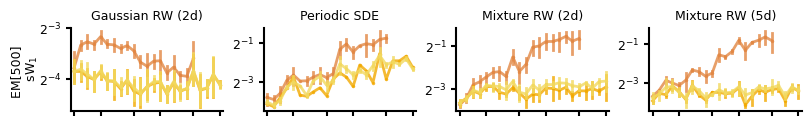

In [286]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size-0.15, metric=["swd"], fig_legend=False, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("EM[500] \n\u00A0sW$_1$", x=-0.2)
        ax.set_yscale("log", base=2)
        ax.set_xlabel("")
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        ax.set_xticklabels([])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_em.svg", transparent=True)

    plt.show()

(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (metric=='swd')
2.0
(8.0, 1.1)
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='simple2dstationary') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='periodic_sde') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_2d') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_5d') & (metric=='swd')


/tmp/ipykernel_498800/1634441737.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1634441737.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1634441737.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1634441737.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found bec

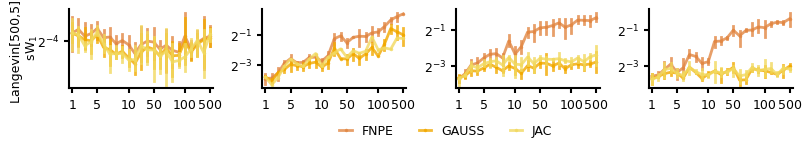

In [285]:

colors = {"pc_fnpe": "#e28743", "pc_gaus": "#f2a900", "pc_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size - 0.2, metric=["swd"], fig_legend=True, sampler=["pc_fnpe", "pc_gaus", "pc_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("Langevin[500,5] \n\u00A0sW$_1$", x=-0.2)
        ax.set_yscale("log", base=2)
        ax.set_title("")
        ax.set_xlabel("")
        
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_pc.svg", transparent=True)

    plt.show()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (metric=='swd')
2.0
(8.0, 1.1500000000000001)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='periodic_sde') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_2d') & (metric=='swd')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (metric=='swd')


/tmp/ipykernel_498800/2534570843.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/2534570843.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/2534570843.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/2534570843.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/2534570843.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/2534570843.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

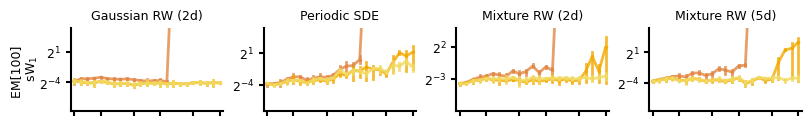

In [284]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100kT100",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size-0.15, metric=["swd"], fig_legend=False, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("EM[100] \n\u00A0sW$_1$", x=-0.2)
        ax.set_yscale("log", base=2)
        ax.set_xlabel("")
        if i > 0:
            ax.set_ylabel("")
            
        ax.set_ylim(0,32)
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        ax.set_xticklabels([])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_em100.svg", transparent=True)

    plt.show()

(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (metric=='swd')
2.0
(8.0, 1.1)
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='simple2dstationary') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='periodic_sde') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_2d') & (metric=='swd')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_5d') & (metric=='swd')


/tmp/ipykernel_498800/3086806709.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/3086806709.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/3086806709.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/3086806709.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/3086806709.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,32)
/tmp/ipykernel_498800/3086806709.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

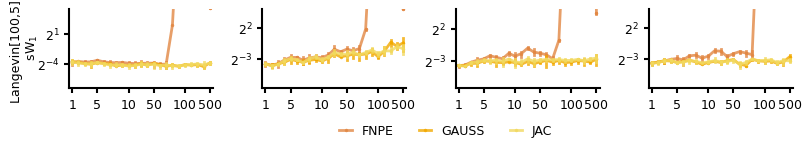

In [283]:

colors = {"pc_fnpe": "#e28743", "pc_gaus": "#f2a900", "pc_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100kT100",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size - 0.2, metric=["swd"], fig_legend=True, sampler=["pc_fnpe", "pc_gaus", "pc_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("Langevin[100,5] \n\u00A0sW$_1$", x=-0.2)
        ax.set_yscale("log", base=2)
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_ylim(0,32)
        
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_pc100.svg", transparent=True)

    plt.show()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (metric=='c2st')
2.0
(8.0, 1.1500000000000001)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='periodic_sde') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_2d') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (metric=='c2st')


/tmp/ipykernel_498800/352111633.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/352111633.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/352111633.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/352111633.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

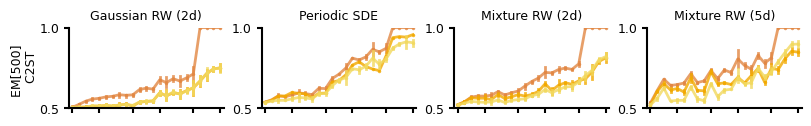

In [282]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size-0.15, metric=["c2st"], fig_legend=False, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("EM[500] \n\u00A0C2ST", x=-0.2)
        #ax.set_yscale("log", base=2)
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        ax.set_xticklabels([])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_em_c2st.svg", transparent=True)

    plt.show()

(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (metric=='c2st')
2.0
(8.0, 1.1)
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='simple2dstationary') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='periodic_sde') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_2d') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_5d') & (metric=='c2st')


/tmp/ipykernel_498800/4094043857.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4094043857.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4094043857.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/4094043857.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found bec

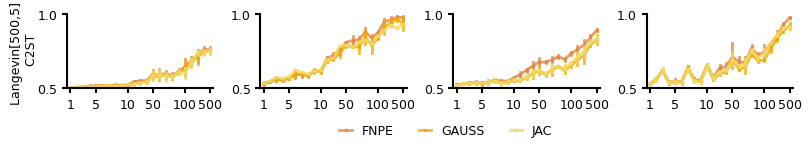

In [281]:

colors = {"pc_fnpe": "#e28743", "pc_gaus": "#f2a900", "pc_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100k",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size - 0.2, metric=["c2st"], fig_legend=True, sampler=["pc_fnpe", "pc_gaus", "pc_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("Langevin[500,5] \n\u00A0C2ST", x=-0.2)
        #ax.set_yscale("log", base=2)
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.0])
        ax.set_title("")
        ax.set_xlabel("")
        
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_pc_c2st.svg", transparent=True)

    plt.show()

(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (metric=='c2st')
2.0
(8.0, 1.1500000000000001)
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='simple2dstationary') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='periodic_sde') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_2d') & (metric=='c2st')
(sampler=='em_fnpe'|sampler=='em_gaus'|sampler=='em_jac') & (task=='mixture_rw_5d') & (metric=='c2st')


/tmp/ipykernel_498800/2387908627.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/2387908627.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/2387908627.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/2387908627.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found bec

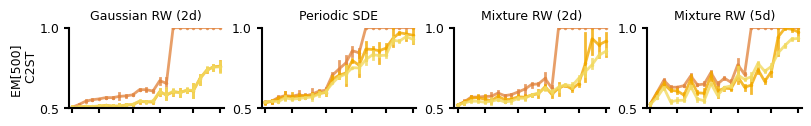

In [289]:

colors = {"em_fnpe": "#e28743", "em_gaus": "#f2a900", "em_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100kT100",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size-0.15, metric=["c2st"], fig_legend=False, sampler=["em_fnpe", "em_gaus", "em_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("EM[500] \n\u00A0C2ST", x=-0.2)
        #ax.set_yscale("log", base=2)
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.])
        ax.set_xlabel("")
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        ax.set_xticklabels([])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_em_c2st100.svg", transparent=True)

    plt.show()

(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (metric=='c2st')
2.0
(8.0, 1.1)
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='simple2dstationary') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='periodic_sde') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_2d') & (metric=='c2st')
(sampler=='pc_fnpe'|sampler=='pc_gaus'|sampler=='pc_jac') & (task=='mixture_rw_5d') & (metric=='c2st')


/tmp/ipykernel_498800/1788521013.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1788521013.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1788521013.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
/tmp/ipykernel_498800/1788521013.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1,5,10, 50,100,500])
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found bec

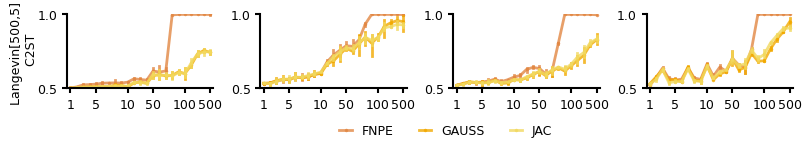

In [290]:

colors = {"pc_fnpe": "#e28743", "pc_gaus": "#f2a900", "pc_jac": "#f2d95f"}
with use_style("pyloric"):
    idxs = [2,3,4,5,6,7,8,9,10,11,21,31,41,51,61, 71,81,91,101,201,301,401,501]
    fig, axes = multi_plot("../../results/bm_sampler100kT100",  "task", "metric", partial(plot_metric_by_eval_steps, hue="sampler", lw=2., alpha=0.8), legend_bbox_to_anchor=(0.55, -0.3),color_map=colors, figsize_per_col=col_size+0.5, figsize_per_row=row_size - 0.2, metric=["c2st"], fig_legend=True, sampler=["pc_fnpe", "pc_gaus", "pc_jac"], legend_ncol=3, legend_kwargs={"handlelength":1})
    for i,ax in enumerate(axes[0,:]):
        # ax.set_xticklabels([2,11,51,101])
        # ax.set_xticks([0,10,15,20])
        axes[0,0].set_ylabel("Langevin[500,5] \n\u00A0C2ST", x=-0.2)
        #ax.set_yscale("log", base=2)
        ax.set_ylim(0.5,1.)
        ax.set_yticks([0.5,1.0])
        ax.set_title("")
        ax.set_xlabel("")
        
        if i > 0:
            ax.set_ylabel("")
        
        
 
        # if i < len(axes[:,0])-1:
        #     ax.set_xticklabels([])
        #     ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
        # else:
        ax.set_xticklabels([1,5,10, 50,100,500])
        ax.set_xticks([idxs.index(i) for i in [2,6,11, 51,101,501]])
            

    #axes[2,0].set_ylabel("Mix. RW")
    
    fig.savefig("samplers_swd_full_pc_c2st100.svg", transparent=True)

    plt.show()

In [257]:
df = query("../../results/bm_sampler100k")[["sampler", "eval_num_steps", "time_eval"]]

In [263]:
df["time_eval"] = df["time_eval"].apply(lambda x: float(x) if x != "[None]" else 0.)

In [264]:
stats = df.groupby(["sampler", "eval_num_steps"]).mean()

In [279]:
stats.unstack("sampler")

time_eval                                                 
sampler          em_fnpe   em_gaus    em_jac   pc_fnpe  pc_gaus    pc_jac
eval_num_steps                                                           
2.0             0.315068  1.631525  1.936641  0.573654  1.71064  2.516432
3.0             0.286994  1.631525  1.936641  0.573654  1.71064  2.516432
4.0             0.286994  1.631525  1.936641  0.573654  1.71064  2.516432
5.0             0.286994  1.631525  1.936641  0.573654  1.71064  2.516432
6.0             0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
7.0             0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
8.0             0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
9.0             0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
10.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
11.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
21.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
31.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
41.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
51.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
61.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
71.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
81.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
91.0            0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
101.0           0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
201.0           0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
301.0           0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
401.0           0.286994  1.631525  1.936641  0.573654  1.65622  2.516432
501.0           0.286994  1.631525  1.936641  0.573654  1.65622  2.516432